In [22]:
# === IMPORTS ===
import pandas as pd
import sqlite3
import os

# === PATH SETUP ===
BASE_DIR = os.path.abspath("..")  # Assumes notebook is in 'notebooks/'
CSV_PATH = os.path.join(BASE_DIR, "data", "pun_target.csv")
DB_PATH = os.path.join(BASE_DIR, "db", "data.db")
OUTPUT_PATH = os.path.join(BASE_DIR, "data", "energy_dataset.csv")

# === LOAD TARGET (PUN) CSV ===
df_target = pd.read_csv(CSV_PATH, delimiter=";", encoding="utf-8")
df_target.columns = [col.strip().lower() for col in df_target.columns]
df_target.rename(columns={"€/mwh": "target_pun"}, inplace=True)
df_target = df_target[["target_pun"]].copy()  # preserve only target column

# === CREATE FULL DATE RANGE ===
full_dates = pd.DataFrame({"date": pd.date_range(start="2020-01-01", end="2024-12-31").date})

# === LOAD DATA FROM SQLITE ===
conn = sqlite3.connect(DB_PATH)

# --- Commodity Features ---
commodity_df = pd.read_sql("SELECT * FROM commodity_prices", conn, parse_dates=["date"])
commodity_df["date"] = commodity_df["date"].dt.date
commodity_pivot = commodity_df.pivot(index="date", columns="commodity", values="price").add_suffix("_Price").reset_index()

# --- Load Forecast Features ---
load_df = pd.read_sql("SELECT * FROM load_forecast", conn, parse_dates=["date"])
load_df["date"] = load_df["date"].dt.date
load_pivot = load_df.pivot(index="date", columns="zone", values="load_mw").add_suffix("_Load").reset_index()

# --- Weather Features ---
weather_df = pd.read_sql("SELECT * FROM weather_data", conn, parse_dates=["time"])
weather_df["date"] = weather_df["time"].dt.date
weather_features = ["tavg", "tmin", "tmax", "wspd", "pres"]
weather_agg = weather_df.groupby(["date", "city"])[weather_features].mean().reset_index()
weather_pivot = weather_agg.pivot(index="date", columns="city", values=weather_features)
weather_pivot.columns = [f"{city}_{feature}" for feature, city in weather_pivot.columns]
weather_pivot = weather_pivot.reset_index()

# --- PUN Price Historical (pun_prices table) ---
pun_df = pd.read_sql("SELECT * FROM pun_prices", conn, parse_dates=["date"])
pun_df["date"] = pun_df["date"].dt.date
pun_df.rename(columns={"price": "pun_Price"}, inplace=True)

conn.close()

# === MERGE ALL FEATURES BY DATE ===
df = full_dates.copy()
df = df.merge(pun_df, on="date", how="left")
df = df.merge(commodity_pivot, on="date", how="left")
df = df.merge(load_pivot, on="date", how="left")
df = df.merge(weather_pivot, on="date", how="left")

# === ADD TARGET COLUMN BY POSITION (not date) ===
df.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df["target_pun"] = df_target["target_pun"]

# === SAVE FINAL DATASET TO CSV ===
df.to_csv(OUTPUT_PATH, index=False)
print(f"✅ Final dataset saved to: {OUTPUT_PATH}")
print("📊 DataFrame shape:", df.shape)

# === PREVIEW ===
df.head()

✅ Final dataset saved to: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\data\energy_dataset.csv
📊 DataFrame shape: (1827, 61)


,date,pun_Price,brent_Price,coal_Price,crude_oil_Price,gasoline_Price,ttf_gas_Price,Calabria_Load,Centre-North_Load,Centre-South_Load,...,bari_pres,bologna_pres,cagliari_pres,milano_pres,napoli_pres,palermo_pres,roma_pres,torino_pres,venezia_pres,target_pun
0,2020-01-01,35.792118,66.3929,NaN,61.1925,1.7168,NaN,NaN,59445.0,100236.0,...,1028.4,1031.2,1031.1,1031.0,1028.4,1028.6,1028.8,1029.7,1031.3,45.745415
1,2020-01-02,45.745415,66.2512,NaN,61.0050,1.7155,12.073,NaN,84763.0,125771.0,...,1030.5,1032.5,1031.9,1032.7,1029.5,1029.4,1029.8,1031.6,1031.9,43.938159
2,2020-01-03,43.938159,68.6226,67.5,62.8565,1.7628,12.985,NaN,85840.0,131904.0,...,1027.8,1027.4,1030.3,1027.6,1027.8,1028.9,1027.8,1026.9,1027.3,44.208705
3,2020-01-04,44.208705,NaN,NaN,NaN,NaN,NaN,NaN,69636.0,118140.0,...,1023.1,1023.5,1025.8,1023.8,1023.5,1024.8,1023.5,1023.3,1023.2,38.060425
4,2020-01-05,38.060425,69.4577,NaN,63.5387,NaN,NaN,NaN,65449.0,110105.0,...,1022.1,1027.5,1025.8,1027.6,1023.9,1022.6,1024.6,1026.2,1028.1,39.923403


In [23]:
# === FORWARD FILL COMMODITY PRICES ===
commodity_cols = [col for col in df.columns if col.endswith("_Price")]
df[commodity_cols] = df[commodity_cols].ffill()
print("🔁 Applied forward fill to commodity price columns.")

🔁 Applied forward fill to commodity price columns.


In [24]:
# === ANALYSE MISSING VALUES ===
missing_info = (
    df.isnull().sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(df)) * 100)
    .sort_values("missing_pct", ascending=False)
)

print("📉 Missing value analysis (top columns):")
print(missing_info[missing_info["missing_count"] > 0].head(20)) 

📉 Missing value analysis (top columns):
                   missing_count  missing_pct
Calabria_Load                451    24.685276
Centre-South_Load             95     5.199781
Italy_Load                    95     5.199781
Centre-North_Load             95     5.199781
North_Load                    95     5.199781
Sardinia_Load                 95     5.199781
Sicily_Load                   95     5.199781
South_Load                    95     5.199781
coal_Price                     2     0.109469
ttf_gas_Price                  1     0.054735


In [25]:
# === DROP columns with missing percentage > 20% ===
missing_pct = df.isnull().mean() * 100
cols_to_drop = missing_pct[missing_pct > 20].index

if len(cols_to_drop) > 0:
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"🗑️ Dropped columns with >20% missing values: {list(cols_to_drop)}")
else:
    print("✅ No columns with >20% missing values")

🗑️ Dropped columns with >20% missing values: ['Calabria_Load']


In [26]:
# === CREATE TIME-BASED & LAG FEATURES ===
if "date" in df.columns:
    df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek  # 0=Monday, 6=Sunday
    df["month"] = pd.to_datetime(df["date"]).dt.month
    df["is_sunday_or_holiday"] = df["day_of_week"].isin([6]).astype(int)  # holiday list can be added later
else:
    print("⚠️ 'date' column not found, time features not created.")

# === CREATE LAG AND ROLLING FEATURES FOR PUN ===
if "pun_Price" in df.columns:
    df["pun_Price_lag1"] = df["pun_Price"].shift(1)
    df["pun_Price_rolling7_mean"] = df["pun_Price"].rolling(window=7).mean()
    df["pun_Price_rolling7_std"] = df["pun_Price"].rolling(window=7).std()
    print("📈 Created lag and rolling features for pun_Price.")
else:
    print("⚠️ 'pun_Price' column not found, lag features not created.")

# === DROP ROWS WITH ANY REMAINING NaNs ===
nan_rows_before = df.isnull().any(axis=1).sum()
df.dropna(inplace=True)
print(f"❌ Dropped {nan_rows_before} rows containing missing values.")

📈 Created lag and rolling features for pun_Price.
❌ Dropped 101 rows containing missing values.


In [27]:
# === DROP ROWS WITH ANY REMAINING NaNs ===
nan_rows_before = df.isnull().any(axis=1).sum()
df.dropna(inplace=True)
print(f"❌ Dropped {nan_rows_before} rows containing missing values.")

# === ANALYSE REMAINING MISSING VALUES ===
missing_info = (
    df.isnull().sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(df)) * 100)
    .sort_values("missing_pct", ascending=False)
)

print("📉 Missing value analysis (top columns):")
print(missing_info[missing_info["missing_count"] > 0].head(20))

# === PREVIEW ===
print("📊 DataFrame shape:", df.shape)
df.head()

❌ Dropped 0 rows containing missing values.
📉 Missing value analysis (top columns):
Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []
📊 DataFrame shape: (1726, 66)


,date,pun_Price,brent_Price,coal_Price,crude_oil_Price,gasoline_Price,ttf_gas_Price,Centre-North_Load,Centre-South_Load,Italy_Load,...,roma_pres,torino_pres,venezia_pres,target_pun,day_of_week,month,is_sunday_or_holiday,pun_Price_lag1,pun_Price_rolling7_mean,pun_Price_rolling7_std
6,2020-01-07,52.590938,68.2700,67.50,62.5100,1.7858,11.929,87563.0,136874.0,845779.0,...,1025.0,1026.4,1027.7,47.919989,1,1,0,39.923403,42.894166,5.591728
7,2020-01-08,47.919989,64.7900,67.50,59.4600,1.6676,11.964,91985.0,142641.0,900505.0,...,1027.2,1030.2,1030.6,55.440532,2,1,0,52.590938,44.626719,4.854760
8,2020-01-09,55.440532,65.3377,68.95,59.5500,1.6658,12.179,94804.0,139809.0,901355.0,...,1028.3,1026.3,1027.0,52.978107,3,1,0,47.919989,46.011736,6.372745
9,2020-01-10,52.978107,65.0210,70.90,59.0841,1.6687,11.940,93598.0,136292.0,902371.0,...,1025.4,1023.6,1025.0,45.419283,4,1,0,55.440532,47.303157,6.785125
10,2020-01-11,45.419283,65.0210,70.90,59.0841,1.6687,11.940,72734.0,125432.0,753652.0,...,1024.5,1028.0,1028.0,45.060714,5,1,0,52.978107,47.476097,6.708099


C:\Users\QT153ZL\AppData\Local\Temp\ipykernel_18480\4113536869.py:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\QT153ZL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


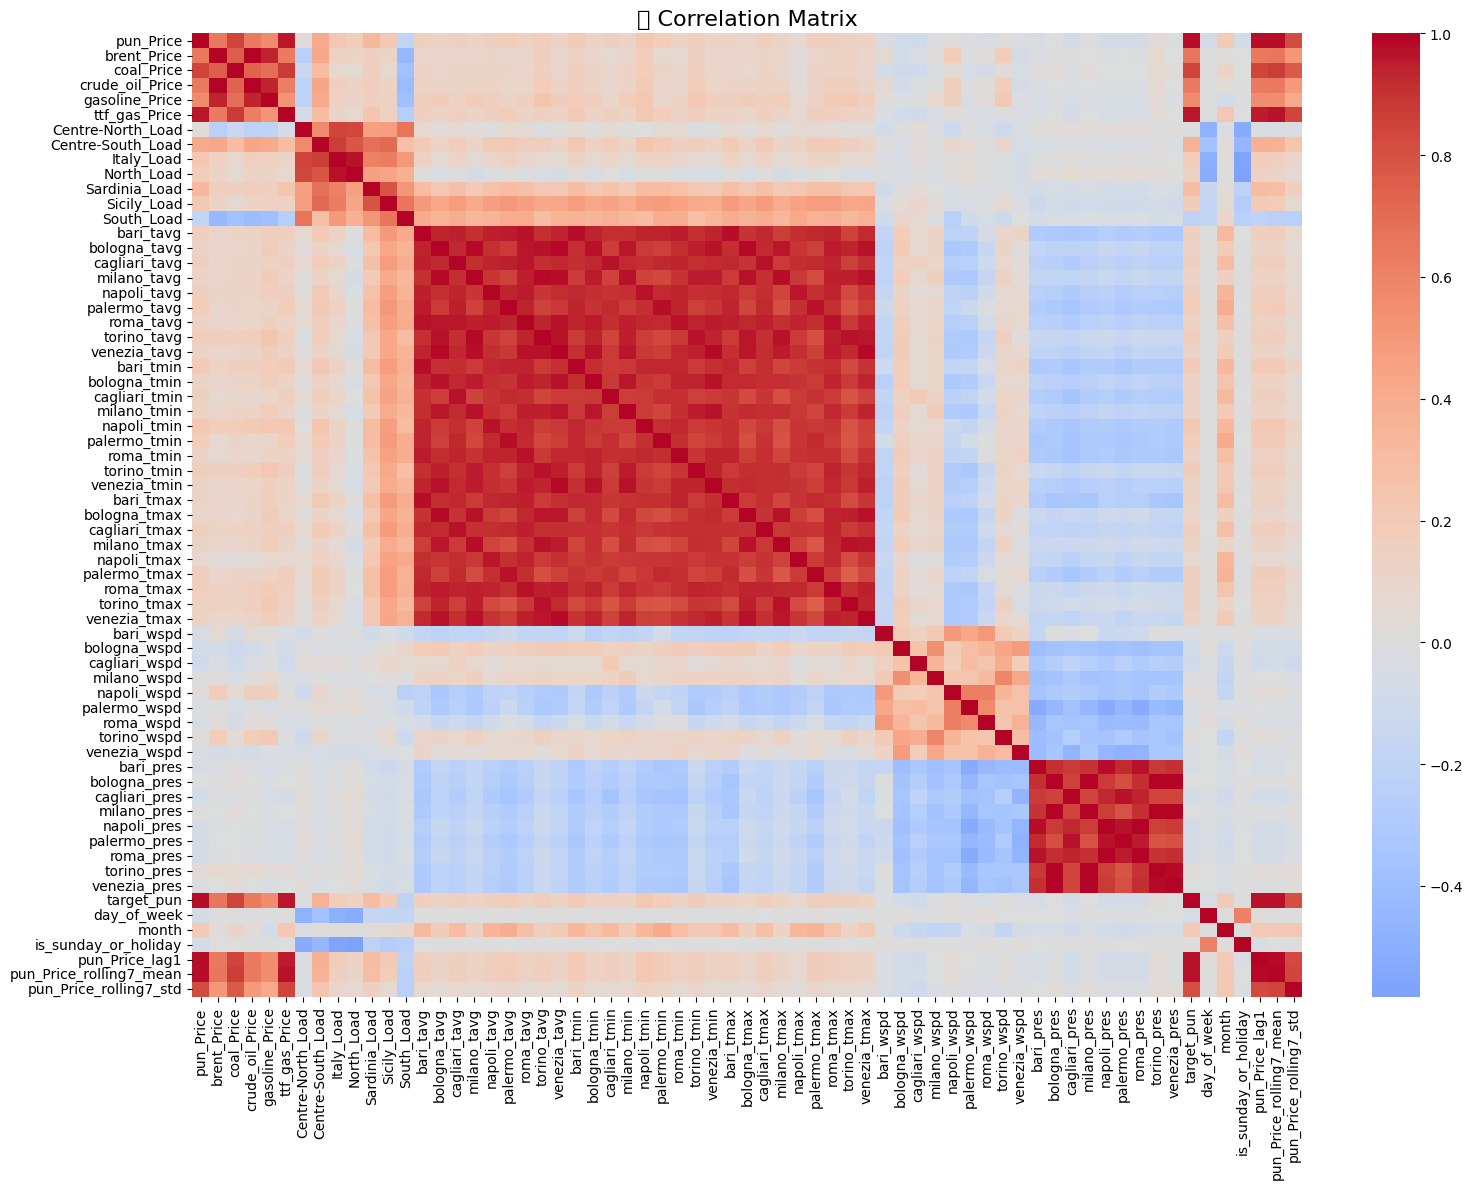

📈 Correlation with target_pun (descending order):
pun_Price                  0.980403
pun_Price_rolling7_mean    0.972154
pun_Price_lag1             0.964796
ttf_gas_Price              0.961877
coal_Price                 0.846286
                             ...   
palermo_pres              -0.065974
cagliari_pres             -0.071575
bologna_wspd              -0.081767
cagliari_wspd             -0.097980
South_Load                -0.214056
Name: target_pun, Length: 64, dtype: float64


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# === CORRELATION MATRIX ===
correlation_matrix = df.corr(numeric_only=True)

# === HEATMAP PLOT ===
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("🔍 Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

# === CORRELATION WITH TARGET (ORDERED) ===
target_corr = (
    correlation_matrix["target_pun"]
    .drop("target_pun")  # Remove self-correlation
    .sort_values(ascending=False)
)

print("📈 Correlation with target_pun (descending order):")
print(target_corr)

In [29]:
import os

# === SAVE TO CSV ===
BASE_DIR = os.path.abspath("..")
OUTPUT_PATH = os.path.join(BASE_DIR, "data", "total_pun_model_features.csv")
df.to_csv(OUTPUT_PATH, index=False)

print(f"✅ Features dataset saved to: {OUTPUT_PATH}")

# === SELECT MOST RELEVANT FEATURES BASED ON CORRELATION WITH TARGET ===
correlation_matrix = df.corr(numeric_only=True)
target_corr = correlation_matrix["target_pun"].drop("target_pun")  # exclude self-correlation

# Sort by absolute correlation and filter by threshold (e.g., > 0.2)
relevant_features = target_corr[abs(target_corr) > 0.2].sort_values(ascending=False)

print("📊 Top relevant features correlated with target_pun:")
print(relevant_features)

# Add 'date' to selected columns
selected_columns = ["date"] + relevant_features.index.tolist() + ["target_pun"]
df_selected = df[selected_columns].copy()

# === SAVE TO CSV ===
BASE_DIR = os.path.abspath("..")
OUTPUT_PATH = os.path.join(BASE_DIR, "data", "pun_model_features.csv")
df_selected.to_csv(OUTPUT_PATH, index=False)

print(f"✅ Relevant features dataset saved to: {OUTPUT_PATH}")

✅ Features dataset saved to: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\data\total_pun_model_features.csv
📊 Top relevant features correlated with target_pun:
pun_Price                  0.980403
pun_Price_rolling7_mean    0.972154
pun_Price_lag1             0.964796
ttf_gas_Price              0.961877
coal_Price                 0.846286
pun_Price_rolling7_std     0.816107
brent_Price                0.654975
crude_oil_Price            0.643692
gasoline_Price             0.563898
Centre-South_Load          0.373326
Sardinia_Load              0.307260
napoli_tmin                0.229452
month                      0.207687
bari_tmin                  0.206072
South_Load                -0.214056
Name: target_pun, dtype: float64
✅ Relevant features dataset saved to: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\data\pun_model_features.csv


In [30]:
# === Imports ===
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sqlite3

# === A. Generic True vs Predicted plot with image saving ===
def plot_predictions(y_true, y_pred, model_name="Model", label="", save=True, image_format="png"):
    """Plot for general models (e.g. tree-based). Saves image and returns its path."""
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.values, label="True", linewidth=2)
    plt.plot(y_pred, label="Predicted", linestyle="--", linewidth=2)
    plt.title(f"{model_name} - True vs Predicted {label}")
    plt.xlabel("Samples")
    plt.ylabel("PUN €/MWh")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Create images/ directory if it doesn't exist
    image_dir = os.path.abspath(os.path.join("..", "images"))
    os.makedirs(image_dir, exist_ok=True)
    filename = f"{model_name}.{image_format}"
    image_path = os.path.join(image_dir, filename)

    if save:
        plt.savefig(image_path)
        print(f"📸 Plot saved to: {image_path}")

    plt.close()
    return image_path


# === B. True vs Predicted plot for linear models (Lasso, Ridge, SVR) ===
def plot_predictions_lm(y_true, y_pred, model_name="Model", label="", save=True, image_format="png"):
    """Plot specifically designed for linear models. Also saves image and returns its path."""
    y_true_array = y_true.values if hasattr(y_true, "values") else np.array(y_true)

    plt.figure(figsize=(10, 4))
    plt.plot(y_true_array, label="True", linewidth=2)
    plt.plot(y_pred, label="Predicted", linestyle="--", linewidth=2)
    plt.title(f"{model_name} - True vs Predicted {label}")
    plt.xlabel("Samples")
    plt.ylabel("PUN €/MWh")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    image_dir = os.path.abspath(os.path.join("..", "images"))
    os.makedirs(image_dir, exist_ok=True)
    filename = f"{model_name}.{image_format}"
    image_path = os.path.join(image_dir, filename)

    if save:
        plt.savefig(image_path)
        print(f"📸 Plot salvato: {image_path}")

    plt.close()
    return image_path

# === Model evaluation ===
def evaluate(y_true, y_pred, model_name="Model", label=""):
    """Computes MAE, RMSE and R². Prints results and returns them as dictionary."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"📊 {model_name} Evaluation {label}")
    print(f"MAE:  {mae:.4f} €/MWh")
    print(f"RMSE: {rmse:.4f} €/MWh")
    print(f"R²:   {r2:.4f}\n")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# === Save results to SQLite ===
def save_model_results_to_db(model_name, val_metrics, test_metrics, image_path):
    """
    Saves model evaluation metrics and plot image path into the 'model_results' table in data.db.

    Args:
        model_name (str): Name of the model (e.g. 'LassoCV')
        val_metrics (dict): Dictionary with validation metrics (MAE, RMSE, R²)
        test_metrics (dict): Dictionary with test metrics (MAE, RMSE, R²)
        image_path (str): Absolute path of the saved prediction plot
    """
    db_path = os.path.abspath(os.path.join("..", "db", "data.db"))
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Create table if it does not exist
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS model_results (
            model_name TEXT PRIMARY KEY,
            val_mae REAL,
            val_rmse REAL,
            val_r2 REAL,
            test_mae REAL,
            test_rmse REAL,
            test_r2 REAL,
            image_path TEXT
        )
    """)

    # Insert or update model results
    cursor.execute("""
        INSERT OR REPLACE INTO model_results (
            model_name, val_mae, val_rmse, val_r2,
            test_mae, test_rmse, test_r2, image_path
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        model_name,
        val_metrics["MAE"], val_metrics["RMSE"], val_metrics["R2"],
        test_metrics["MAE"], test_metrics["RMSE"], test_metrics["R2"],
        image_path
    ))

    conn.commit()
    conn.close()
    print(f"✅ Results saved for {model_name}")

In [11]:
# === IMPORTS ===
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# === 1. Parse 'date' column ===
df["date"] = pd.to_datetime(df["date"])

# === 2. Temporal split: Train (<=2022), Validation (2023), Test (2024) ===
train_df = df[df["date"].dt.year <= 2022].copy()
val_df   = df[df["date"].dt.year == 2023].copy()
test_df  = df[df["date"].dt.year == 2024].copy()

X_train = train_df.drop(columns=["target_pun", "date"])
y_train = train_df["target_pun"]
X_val   = val_df.drop(columns=["target_pun", "date"])
y_val   = val_df["target_pun"]
X_test  = test_df.drop(columns=["target_pun", "date"])
y_test  = test_df["target_pun"]

# === 3. Define hyperparameter search space ===
param_dist = {
    "iterations": [300, 500, 800],
    "learning_rate": [0.01, 0.03, 0.05],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5, 7],
    "bagging_temperature": [0, 0.5, 1, 2],
    "random_strength": [0.5, 1, 2],
    "border_count": [32, 64, 128]
}

# === 4. Initialize base CatBoost model ===
base_cat = CatBoostRegressor(
    loss_function="RMSE",
    verbose=0,
    random_state=42
)

# === 5. RandomizedSearchCV for hyperparameter tuning ===
random_search = RandomizedSearchCV(
    estimator=base_cat,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# === 6. Train model on training set ===
random_search.fit(X_train, y_train)

# === 7. Extract best model and print best parameters ===
best_cat = random_search.best_estimator_
print("✅ Best hyperparameters:")
print(random_search.best_params_)
print()

# === 8. Make predictions ===
y_val_pred  = best_cat.predict(X_val)
y_test_pred = best_cat.predict(X_test)

# === 9. Evaluate and visualize results ===
val_metrics  = evaluate(y_val, y_val_pred, model_name="CatBoostRegressor", label="(Validation)")
test_metrics = evaluate(y_test, y_test_pred, model_name="CatBoostRegressor", label="(Test)")
image_path   = plot_predictions(y_test, y_test_pred, model_name="CatBoostRegressor", label="(Test)")

# === 10. Save results to database ===
save_model_results_to_db("CatBoostRegressor", val_metrics, test_metrics, image_path)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best hyperparameters:
{'random_strength': 0.5, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 4, 'border_count': 64, 'bagging_temperature': 0}

📊 CatBoostRegressor Evaluation (Validation)
MAE:  10.2533 €/MWh
RMSE: 13.4251 €/MWh
R²:   0.7312

📊 CatBoostRegressor Evaluation (Test)
MAE:  10.4217 €/MWh
RMSE: 12.8206 €/MWh
R²:   0.6470

📸 Plot saved to: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\images\CatBoostRegressor.png
✅ Results saved for CatBoostRegressor


In [12]:
# === IMPORTS ===
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# === 1. Parse 'date' column ===
df_selected["date"] = pd.to_datetime(df_selected["date"])

# === 2. Temporal split: Train (<=2022), Validation (2023), Test (2024) ===
train_df = df_selected[df_selected["date"].dt.year <= 2022].copy()
val_df   = df_selected[df_selected["date"].dt.year == 2023].copy()
test_df  = df_selected[df_selected["date"].dt.year == 2024].copy()

X_train = train_df.drop(columns=["target_pun", "date"])
y_train = train_df["target_pun"]
X_val   = val_df.drop(columns=["target_pun", "date"])
y_val   = val_df["target_pun"]
X_test  = test_df.drop(columns=["target_pun", "date"])
y_test  = test_df["target_pun"]

# === 3. Feature scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# === 4. LassoCV: cross-validated alpha selection ===
lasso_cv_model = LassoCV(
    alphas=np.logspace(-4, 1, 50),  # search alpha from 0.0001 to 10
    cv=5,
    max_iter=10000,
    random_state=42
)
lasso_cv_model.fit(X_train_scaled, y_train)

# === 5. Best alpha found ===
print(f"✅ Best alpha: {lasso_cv_model.alpha_:.5f}\n")

# === 6. Predictions ===
y_val_pred  = lasso_cv_model.predict(X_val_scaled)
y_test_pred = lasso_cv_model.predict(X_test_scaled)

# === 7. Evaluation & visualization ===
val_metrics  = evaluate(y_val, y_val_pred, model_name="LassoCV", label="(Validation)")
test_metrics = evaluate(y_test, y_test_pred, model_name="LassoCV", label="(Test)")
image_path   = plot_predictions_lm(y_test, y_test_pred, model_name="LassoCV", label="(Test)")

# === 8. Save results to database ===
save_model_results_to_db("LassoCV", val_metrics, test_metrics, image_path)


✅ Best alpha: 1.93070

📊 LassoCV Evaluation (Validation)
MAE:  9.8667 €/MWh
RMSE: 12.7032 €/MWh
R²:   0.7594

📊 LassoCV Evaluation (Test)
MAE:  7.9504 €/MWh
RMSE: 10.6331 €/MWh
R²:   0.7572

📸 Plot salvato: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\images\LassoCV.png
✅ Results saved for LassoCV


In [18]:
# === IMPORTS ===
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# === 1. Parse 'date' column ===
df["date"] = pd.to_datetime(df["date"])

# === 2. Temporal split: Train (<=2022), Validation (2023), Test (2024) ===
train_df = df[df["date"].dt.year <= 2022].copy()
val_df   = df[df["date"].dt.year == 2023].copy()
test_df  = df[df["date"].dt.year == 2024].copy()

X_train = train_df.drop(columns=["target_pun", "date"])
y_train = train_df["target_pun"]
X_val   = val_df.drop(columns=["target_pun", "date"])
y_val   = val_df["target_pun"]
X_test  = test_df.drop(columns=["target_pun", "date"])
y_test  = test_df["target_pun"]

# === 3. Hyperparameter grid for RandomizedSearchCV ===
param_grid = {
    "n_estimators": [300, 500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10],
    "min_child_samples": [10, 20, 30],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0, 0.1, 0.5]
}

# === 4. Base model ===
base_model = LGBMRegressor(random_state=42)

# === 5. Time series cross-validation ===
tscv = TimeSeriesSplit(n_splits=3)

# === 6. Hyperparameter tuning ===
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# === 7. Fit on training set only ===
random_search.fit(X_train, y_train)

# === 8. Best model selected ===
best_lgbm = random_search.best_estimator_
print("✅ Best hyperparameters:")
print(random_search.best_params_)
print()

# === 9. Predictions on validation and test sets ===
y_val_pred  = best_lgbm.predict(X_val)
y_test_pred = best_lgbm.predict(X_test)

# === 10. Evaluation and saving ===
val_metrics  = evaluate(y_val, y_val_pred, model_name="LGBMRegressor", label="(Validation)")
test_metrics = evaluate(y_test, y_test_pred, model_name="LGBMRegressor", label="(Test)")
image_path   = plot_predictions(y_test, y_test_pred, model_name="LGBMRegressor", label="(Test)")
save_model_results_to_db("LGBMRegressor", val_metrics, test_metrics, image_path)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12414
[LightGBM] [Info] Number of data points in the train set: 1030, number of used features: 64
[LightGBM] [Info] Start training from score 153.102226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [19]:
# === IMPORTS ===
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# === 1. Parse 'date' column ===
df["date"] = pd.to_datetime(df["date"])

# === 2. Temporal split: Train (<=2022), Validation (2023), Test (2024) ===
train_df = df[df["date"].dt.year <= 2022].copy()
val_df   = df[df["date"].dt.year == 2023].copy()
test_df  = df[df["date"].dt.year == 2024].copy()

X_train = train_df.drop(columns=["target_pun", "date"])
y_train = train_df["target_pun"]
X_val   = val_df.drop(columns=["target_pun", "date"])
y_val   = val_df["target_pun"]
X_test  = test_df.drop(columns=["target_pun", "date"])
y_test  = test_df["target_pun"]

# === 3. Initialize and train Random Forest model ===
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

rf_model.fit(X_train, y_train)

# === 4. Predictions on validation and test sets ===
y_val_pred  = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# === 5. Evaluation and saving ===
val_metrics  = evaluate(y_val, y_val_pred, model_name="RandomForestRegressor", label="(Validation)")
test_metrics = evaluate(y_test, y_test_pred, model_name="RandomForestRegressor", label="(Test)")
image_path   = plot_predictions(y_test, y_test_pred, model_name="RandomForestRegressor", label="(Test)")
save_model_results_to_db("RandomForestRegressor", val_metrics, test_metrics, image_path)


📊 RandomForestRegressor Evaluation (Validation)
MAE:  15.2251 €/MWh
RMSE: 18.5005 €/MWh
R²:   0.4896

📊 RandomForestRegressor Evaluation (Test)
MAE:  12.6478 €/MWh
RMSE: 15.3200 €/MWh
R²:   0.4959

📸 Plot saved to: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\images\RandomForestRegressor.png
✅ Results saved for RandomForestRegressor


In [20]:
# === IMPORTS ===
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# === 1. Parse 'date' column ===
df_selected["date"] = pd.to_datetime(df_selected["date"])

# === 2. Temporal split: Train (<=2022), Validation (2023), Test (2024) ===
train_df = df_selected[df_selected["date"].dt.year <= 2022].copy()
val_df   = df_selected[df_selected["date"].dt.year == 2023].copy()
test_df  = df_selected[df_selected["date"].dt.year == 2024].copy()

X_train = train_df.drop(columns=["target_pun", "date"])
y_train = train_df["target_pun"]
X_val   = val_df.drop(columns=["target_pun", "date"])
y_val   = val_df["target_pun"]
X_test  = test_df.drop(columns=["target_pun", "date"])
y_test  = test_df["target_pun"]

# === 3. Prepare validation tuning set (Train + Validation) ===
X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([y_train, y_val])

# === 4. Define alpha search space and pipeline (scaling + RidgeCV) ===
ridge_alphas_fine = np.linspace(1, 10, 100)
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=ridge_alphas_fine, scoring="neg_mean_absolute_error", cv=5))
])

# === 5. Fit model on training + validation set ===
ridge_pipeline.fit(X_tune, y_tune)
best_alpha = ridge_pipeline.named_steps["ridge"].alpha_
print(f"✅ Best alpha (refined): {best_alpha:.5f}\n")

# === 6. Predictions on validation and test sets ===
y_val_pred  = ridge_pipeline.predict(X_val)
y_test_pred = ridge_pipeline.predict(X_test)

# === 7. Evaluation and saving ===
val_metrics  = evaluate(y_val, y_val_pred, model_name="RidgeCV", label="(Validation)")
test_metrics = evaluate(y_test, y_test_pred, model_name="RidgeCV", label="(Test)")
image_path   = plot_predictions_lm(y_test, y_test_pred, model_name="RidgeCV", label="(Test)")
save_model_results_to_db("RidgeCV", val_metrics, test_metrics, image_path)


✅ Best alpha (refined): 6.36364

📊 RidgeCV Evaluation (Validation)
MAE:  9.8970 €/MWh
RMSE: 12.8352 €/MWh
R²:   0.7543

📊 RidgeCV Evaluation (Test)
MAE:  8.8277 €/MWh
RMSE: 12.4596 €/MWh
R²:   0.6666

📸 Plot salvato: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\images\RidgeCV.png
✅ Results saved for RidgeCV


In [16]:
# === IMPORTS ===
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd

# === 1. Parse 'date' column ===
df_selected["date"] = pd.to_datetime(df_selected["date"])

# === 2. Temporal split: Train (<=2022), Validation (2023), Test (2024) ===
train_df = df_selected[df_selected["date"].dt.year <= 2022].copy()
val_df   = df_selected[df_selected["date"].dt.year == 2023].copy()
test_df  = df_selected[df_selected["date"].dt.year == 2024].copy()

X_train = train_df.drop(columns=["target_pun", "date"])
y_train = train_df["target_pun"]
X_val   = val_df.drop(columns=["target_pun", "date"])
y_val   = val_df["target_pun"]
X_test  = test_df.drop(columns=["target_pun", "date"])
y_test  = test_df["target_pun"]

# === 3. Feature scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# === 4. Hyperparameter tuning via RandomizedSearchCV ===
param_grid = {
    "C": [0.1, 1, 10, 100, 500],
    "epsilon": [0.01, 0.05, 0.1, 0.5, 1],
    "gamma": ["scale", "auto", 0.01, 0.1, 1]
}

svr = SVR(kernel="rbf")

random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# === 5. Fit model on training set only ===
random_search.fit(X_train_scaled, y_train)

# === 6. Retrieve best model ===
best_svr = random_search.best_estimator_
print("✅ Best hyperparameters:")
print(random_search.best_params_)
print()

# === 7. Predict on validation and test sets ===
y_val_pred  = best_svr.predict(X_val_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

# === 8. Evaluate and save results ===
val_metrics  = evaluate(y_val, y_val_pred, model_name="SVR", label="(Validation)")
test_metrics = evaluate(y_test, y_test_pred, model_name="SVR", label="(Test)")
image_path   = plot_predictions_lm(y_test, y_test_pred, model_name="SVR", label="(Test)")
save_model_results_to_db("SVR", val_metrics, test_metrics, image_path)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best hyperparameters:
{'gamma': 0.01, 'epsilon': 0.01, 'C': 100}

📊 SVR Evaluation (Validation)
MAE:  10.8082 €/MWh
RMSE: 13.7728 €/MWh
R²:   0.7171

📊 SVR Evaluation (Test)
MAE:  9.4015 €/MWh
RMSE: 12.1354 €/MWh
R²:   0.6837

📸 Plot salvato: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\images\SVR.png
✅ Results saved for SVR


In [ ]:
# === IMPORTS ===
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import numpy as np
import pandas as pd

# === 1. Parse 'date' column ===
df["date"] = pd.to_datetime(df["date"])

# === 2. Temporal split: Train (<=2022), Validation (2023), Test (2024) ===
train_df = df[df["date"].dt.year <= 2022].copy()
val_df   = df[df["date"].dt.year == 2023].copy()
test_df  = df[df["date"].dt.year == 2024].copy()

X_train = train_df.drop(columns=["target_pun", "date"])
y_train = train_df["target_pun"]
X_val   = val_df.drop(columns=["target_pun", "date"])
y_val   = val_df["target_pun"]
X_test  = test_df.drop(columns=["target_pun", "date"])
y_test  = test_df["target_pun"]

# === 3. Hyperparameter grid ===
param_grid = {
    "n_estimators": [300, 500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5]
}

# === 4. Base model ===
base_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    early_stopping_rounds=30,
    eval_metric="mae",
    verbosity=0
)

# === 5. TimeSeriesSplit for time-aware cross-validation ===
tscv = TimeSeriesSplit(n_splits=3)

# === 6. RandomizedSearchCV with early stopping using validation set ===
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# === 7. Fit model on training set with validation for early stopping ===
random_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# === 8. Retrieve best model ===
best_model = random_search.best_estimator_
print("✅ Best hyperparameters:")
print(random_search.best_params_)
print()

# === 9. Predict on validation and test sets ===
y_val_pred  = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# === 10. Evaluate and save results ===
val_metrics  = evaluate(y_val, y_val_pred, model_name="XGBRegressor", label="(Validation)")
test_metrics = evaluate(y_test, y_test_pred, model_name="XGBRegressor", label="(Test)")
image_path   = plot_predictions(y_test, y_test_pred, model_name="XGBRegressor", label="(Test)")
save_model_results_to_db("XGBRegressor", val_metrics, test_metrics, image_path)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best hyperparameters:
{'subsample': 0.8, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1.0}

📊 XGBRegressor Evaluation (Validation)
MAE:  11.5506 €/MWh
RMSE: 14.8838 €/MWh
R²:   0.6697

📊 XGBRegressor Evaluation (Test)
MAE:  10.5434 €/MWh
RMSE: 13.4748 €/MWh
R²:   0.6100

📸 Plot saved to: c:\Users\QT153ZL\OneDrive - EY\Desktop\Thesis_new\images\XGBRegressor.png
✅ Results saved for XGBRegressor
